In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 13.8 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 
     |████████████████████████████████| 3.3 MB 34.4 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 29.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm 
import os

import transformers
from transformers import DistilBertTokenizer, RobertaTokenizer, DistilBertTokenizerFast, DistilBertConfig, TFDistilBertModel, BertModel, BertTokenizerFast, DistilBertModel
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Setting Args

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 64

max_length = 128

cuda


# Importing Data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md
dev.txt  test.txt  train.txt


In [ ]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Preprocessing Data and converting it into csv file

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [ ]:
len(train_lines)

210040

## Converting Sentences into list of dictionary

In [ ]:
def preprocess_text_with_line_number(filename):
  """
  returns a list of dictionary of lines data
  
  """

  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
    
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
       abstract_lines += line

  return abstract_samples

In [ ]:
# getting data from file and preocess it
train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')

In [ ]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:2]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11}]

In [ ]:
# convertind dictionary lists into pandas dataframe
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


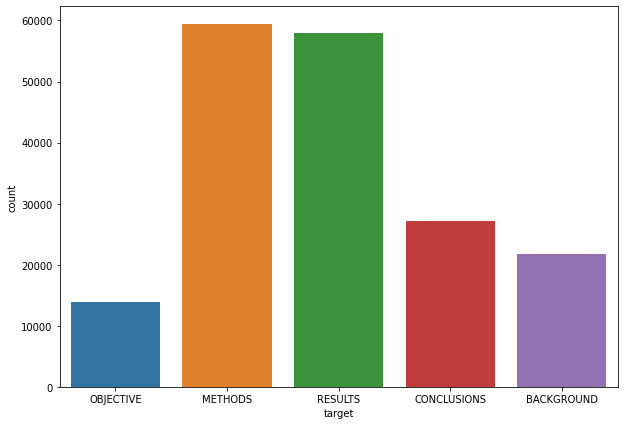

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot('target',data=train_df);

## Preprocessing Data

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print (STOPWORDS[:5])
porter = PorterStemmer()

def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in paranthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we']


In [ ]:
# Apply to dataframe
preprocessed_df = train_df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess)
print (f"{train_df.text.values[0]}\n\n{preprocessed_df.text.values[0]}")

to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .

investigate efficacy weeks daily low dose oral prednisolone improving pain mobility systemic low grade inflammation short term whether effect would sustained weeks older adults moderate severe knee osteoarthritis


## Creating List of Sentences

In [ ]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Spliting Data into train, test and validation dataset

In [ ]:
import collections
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.7
VAL_SIZE = 0.20
TEST_SIZE = 0.10

def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Data
X = preprocessed_df["text"].values
y = preprocessed_df["target"].values

# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (126027,), y_train: (126027,)
X_val: (27006,), y_val: (27006,)
X_test: (27007,), y_test: (27007,)
Sample point: limitations include day postprocedure study duration may confounded natural healing time lack placebo arm → RESULTS


# Encoding target labels

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()

# train_label_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
# val_label_encoded = label_encoder.transform(val_df['target'].to_numpy())
# test_label_encoded = label_encoder.transform(test_df['target'].to_numpy())

# train_label_encoded

In [ ]:
# num_classes = len(label_encoder.classes_)
# class_names = label_encoder.classes_

# num_classes, class_names

In [ ]:
import itertools

class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index

{'BACKGROUND': 0, 'CONCLUSIONS': 1, 'METHODS': 2, 'OBJECTIVE': 3, 'RESULTS': 4}

In [ ]:
class_names = label_encoder.class_to_index.keys()
class_names

dict_keys(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'])

In [ ]:
# converting all target labels into tokens
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)

In [ ]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [15209 19017 41547  9687 40567]
weights: {0: 6.575054244197515e-05, 1: 5.258452963138245e-05, 2: 2.4069126531398175e-05, 3: 0.00010323113451016826, 4: 2.4650578056055415e-05}


# Tokenizer

In [ ]:
import json
from collections import Counter
from more_itertools import take

class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None,
                 pad_token="<PAD>", oov_token="<UNK>",
                 token_to_index=None):
        self.char_level = char_level
        self.separator = "" if self.char_level else " "
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(" ")
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Tokenizer
tokenizer = Tokenizer(char_level=False, num_tokens=60000)
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print(VOCAB_SIZE)

38831


In [ ]:
# Sample of tokens
print (take(5, tokenizer.token_to_index.items()))
print (f"least freq token's freq: {tokenizer.min_token_freq}")

[('<PAD>', 0), ('<UNK>', 1), ('patients', 2), ('group', 3), ('treatment', 4)]
least freq token's freq: 1


In [ ]:
# COnverting texts to sequence of numbers
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

## Padding function

In [ ]:
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

# Creating Skimlit Dataset

In [ ]:
class SkimlitDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __str__(self):
    return f"<Dataset(N={len(self)})>"

  def __getitem__(self, index):
    X = self.X[index]
    y = self.y[index]
    return [X, len(X), y]
  
  def collate_fn(self, batch):
    """Processing on a batch"""
    # Getting Input
    batch = np.array(batch)
    X = batch[:,0]
    seq_lens = batch[:, 1]
    y = batch[:, 2]

    # padding inputs
    X = pad_sequences(sequences=X) # max_seq_len=max_length

    # converting inputs to tensors
    X = torch.LongTensor(X.astype(np.int32))
    seq_lens = torch.LongTensor(seq_lens.astype(np.int32))
    y = torch.LongTensor(y.astype(np.int32))
    return X, seq_lens, y

  def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
    dataloader = DataLoader(dataset=self, batch_size=batch_size, collate_fn=self.collate_fn, shuffle=shuffle, drop_last=drop_last, pin_memory=True)
    return dataloader

## Creating Datasets

In [ ]:
# Create datasets
train_dataset = SkimlitDataset(X=X_train, y=y_train)
val_dataset = SkimlitDataset(X=X_val, y=y_val)
test_dataset = SkimlitDataset(X=X_test, y=y_test)

In [ ]:
train_dataset[12]

[array([  105,   308, 12572,  2754,   159,  4907, 11036,   400,   109,
          333,    34,  1760, 12573,   511,  6297,  3128,     2,  9931]), 18, 0]

## Creating Dataloaders

In [ ]:
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(1970, 422, 422)

In [ ]:
batch_X, batch_seq_lens, batch_y = next(iter(train_dataloader))
batch_X[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


tensor([ 1981,   561,    55,  7061,     5,   244,    51, 10466,  2033,   862,
           19,  1194,    14,   166,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])

# Creating Trainer

In [ ]:
from tqdm.notebook import tqdm

class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None, save_path=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_path = save_path

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0
        acc = 0.0

        # Iterate over train batches
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)
            acc += self.calculate_accuracy(z, targets)

        return loss, acc

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        acc = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)
                acc += self.calculate_accuracy(z, y_true)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, acc, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def calculate_accuracy(self, output, labels):
      output_class = torch.softmax(output, dim=1).argmax(dim=1)
      train_acc = (output_class == labels).sum().item()/len(output)
      return train_acc

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            print(f"<----- Epoch: {epoch+1} ----->")
            # Steps
            train_loss, train_acc = self.train_step(dataloader=train_dataloader)
            val_loss, val_acc, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                if self.save_path is not None:
                  print('Saving Model!!')
                  torch.save(self.model.state_dict(), self.save_path)
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            train_acc = train_acc / len(train_dataloader)
            val_acc = val_acc / len(val_dataloader)

            # Logging
            print(
                f"train Loss: {train_loss:.5f},\t"
                f"train Accuracy: {train_acc:.2f},\n"
                f"val Loss: {val_loss:.5f}, \t"
                f"val Accuracy: {val_acc:.2f}, \n"
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, \t"
                f"_patience: {_patience}"
                "\n"
            )
        return best_model

In [ ]:
def gather_last_relevant_hidden(hiddens, seq_lens):
    """Extract and collect the last relevant
    hidden state based on the sequence length."""
    seq_lens = seq_lens.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(seq_lens):
        out.append(hiddens[batch_index, column_index])
    return torch.stack(out)

# Model.1 Class

In [ ]:
hidden_dim = 128
embedding_dim = 128

In [ ]:
class SkimlitModel(nn.Module):
  def __init__(self, embedding_dim, vocab_size, hidden_dim, n_layers, linear_output, 
               num_classes, padding_idx=0):
    super(SkimlitModel, self).__init__()

    # Initalizing embeddings
    self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

    # LSTM layers
    self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)

    # FC layers
    self.fc1 = nn.Linear(2*hidden_dim, linear_output)
    self.fc2 = nn.Linear(linear_output, num_classes)
    self.dropout = nn.Dropout(0.3)

  def forward(self, inputs):
    x_in, seq_lens = inputs
    x_in = self.embeddings(x_in)

    # RNN outputs 
    out, b_n = self.lstm1(x_in)
    x = gather_last_relevant_hidden(hiddens=out, seq_lens=seq_lens)

    # FC layers output
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
model = SkimlitModel(
    embedding_dim=embedding_dim,
    vocab_size=VOCAB_SIZE,
    hidden_dim=hidden_dim,
    n_layers=2,
    linear_output=64,
    num_classes=NUM_CLASSES,
)

model = model.to(device)
model

SkimlitModel(
  (embeddings): Embedding(38775, 128)
  (lstm1): LSTM(128, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## Training Model

In [ ]:
LEARNING_RATE=1e-4
PATIENCE = 5
NUM_EPOCHS = 25

In [ ]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
trainer = Trainer(
    model=model,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    save_path = '/content/drive/MyDrive/Datasets/SkimLit/skimlit_Pytorch_1.pt', 
)

In [ ]:
best_model = trainer.train(
    NUM_EPOCHS,
    PATIENCE, 
    train_dataloader,
    val_dataloader,
)

<----- Epoch: 1 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


  0%|          | 0/422 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train_loss: 1.19846,	val_loss: 0.97728, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 2 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.90514,	val_loss: 0.88741, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 3 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.81826,	val_loss: 0.85256, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 4 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.75900,	val_loss: 0.83076, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 5 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.70893,	val_loss: 0.82572, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 6 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.66672,	val_loss: 0.83285, 
lr: 1.00E-04, 	_patience: 4

<----- Epoch: 7 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.62742,	val_loss: 0.84665, 
lr: 1.00E-04, 	_patience: 3

<----- Epoch: 8 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.58982,	val_loss: 0.86068, 
lr: 1.00E-04, 	_patience: 2

<----- Epoch: 9 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.55380,	val_loss: 0.87445, 
lr: 1.00E-05, 	_patience: 1

<----- Epoch: 10 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Stopping early!


## Evaluation

In [ ]:
import json
from sklearn.metrics import precision_recall_fscore_support

def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [ ]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

# Determine performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

  0%|          | 0/422 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{
  "precision": 0.7465202343374817,
  "recall": 0.7414744325545229,
  "f1": 0.7435915019180314,
  "num_samples": 27007.0
}


In [ ]:
for key in class_names:
  print(f"{key} : {performance['class'][key]}")

BACKGROUND : {'precision': 0.5508625817965497, 'recall': 0.5682724762196993, 'f1': 0.5594321099531793, 'num_samples': 3259.0}
CONCLUSIONS : {'precision': 0.6203789279112755, 'recall': 0.6587340529931305, 'f1': 0.6389814374107567, 'num_samples': 4076.0}
METHODS : {'precision': 0.8453514739229024, 'recall': 0.8374705155565539, 'f1': 0.8413925407662359, 'num_samples': 8903.0}
OBJECTIVE : {'precision': 0.5511638120333773, 'recall': 0.6045279383429673, 'f1': 0.5766138295428439, 'num_samples': 2076.0}
RESULTS : {'precision': 0.8244525547445255, 'recall': 0.779592775796618, 'f1': 0.8013953763377284, 'num_samples': 8693.0}


# Model.2 Class

* Pretrained Embeddings

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from urllib.request import urlopen
from zipfile import ZipFile

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

--2022-01-27 09:10:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-27 09:10:27 (50.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Unzip the file (may take ~3-5 minutes)
# Downloading glove embeddings files
!wget http://nlp.stanford.edu/data/glove.6B.zip
unzip_data('/content/glove.6B.zip')

--2022-01-27 09:10:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-27 09:10:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-27 09:10:28--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
def load_glove_embeddings(embeddings_file):
    """Load embeddings from a file."""
    embeddings = {}
    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            values = line.split()
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings[word] = embedding
    return embeddings

def make_embeddings_matrix(embeddings, word_index, embedding_dim):
    """Create embeddings matrix to use in Embedding layer."""
    embedding_matrix = np.zeros((len(word_index), embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 128

# Create embeddings
embeddings_file = '/content/glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
glove_embeddings = load_glove_embeddings(embeddings_file=embeddings_file)
embedding_matrix = make_embeddings_matrix(
    embeddings=glove_embeddings, word_index=tokenizer.token_to_index,
    embedding_dim=EMBEDDING_DIM)
print (f"<Embeddings(words={embedding_matrix.shape[0]}, dim={embedding_matrix.shape[1]})>")

<Embeddings(words=38831, dim=300)>


## Model

In [ ]:
class SkimlitModel(nn.Module):
  def __init__(self, embedding_dim, vocab_size, hidden_dim, n_layers, linear_output, num_classes, pretrained_embeddings=None, padding_idx=0):
    super(SkimlitModel, self).__init__()

    # Initalizing embeddings
    if pretrained_embeddings is None:
      self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    else:
      pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
      self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, _weight=pretrained_embeddings, padding_idx=padding_idx)

    # LSTM layers
    self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)

    # FC layers
    self.fc1 = nn.Linear(2*hidden_dim, linear_output)
    self.fc2 = nn.Linear(linear_output, num_classes)
    self.dropout = nn.Dropout(0.3)

  def forward(self, inputs):
    x_in, seq_lens = inputs
    x_in = self.embeddings(x_in)

    # RNN outputs 
    out, b_n = self.lstm1(x_in)
    x = gather_last_relevant_hidden(hiddens=out, seq_lens=seq_lens)

    # FC layers output
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
model = SkimlitModel(
    embedding_dim=EMBEDDING_DIM,
    vocab_size=VOCAB_SIZE,
    hidden_dim=HIDDEN_DIM,
    n_layers=2,
    linear_output= 128,
    num_classes=NUM_CLASSES,
    pretrained_embeddings=embedding_matrix,
)

model = model.to(device)
model

SkimlitModel(
  (embeddings): Embedding(38791, 300, padding_idx=0)
  (lstm1): LSTM(300, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## Training

In [ ]:
LEARNING_RATE=1e-4
PATIENCE = 5
NUM_EPOCHS = 25

# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
trainer = Trainer(
    model=model,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    save_path = '/content/drive/MyDrive/Datasets/SkimLit/skimlit_Pytorch_prtrained_embeddings.pt', 
)

In [ ]:
best_model = trainer.train(
    NUM_EPOCHS,
    PATIENCE, 
    train_dataloader,
    val_dataloader,
)

<----- Epoch: 1 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


  0%|          | 0/422 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Saving Model!!
train_loss: 1.01178,	val_loss: 0.83077, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 2 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Saving Model!!
train_loss: 0.77720,	val_loss: 0.76345, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 3 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Saving Model!!
train_loss: 0.69816,	val_loss: 0.73592, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 4 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Saving Model!!
train_loss: 0.64358,	val_loss: 0.73390, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 5 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.59736,	val_loss: 0.74330, 
lr: 1.00E-04, 	_patience: 4

<----- Epoch: 6 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.55846,	val_loss: 0.76700, 
lr: 1.00E-04, 	_patience: 3

<----- Epoch: 7 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.52014,	val_loss: 0.78657, 
lr: 1.00E-04, 	_patience: 2

<----- Epoch: 8 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.48536,	val_loss: 0.84953, 
lr: 1.00E-05, 	_patience: 1

<----- Epoch: 9 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Stopping early!


In [ ]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

# Determine performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

  0%|          | 0/422 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{
  "precision": 0.7727453824193705,
  "recall": 0.7715036842300145,
  "f1": 0.7716862206945324,
  "num_samples": 27007.0
}


In [ ]:
for key in class_names:
  print(f"{key} : {performance['class'][key]}")

BACKGROUND : {'precision': 0.6041416566626651, 'recall': 0.617674133169684, 'f1': 0.6108329540282202, 'num_samples': 3259.0}
CONCLUSIONS : {'precision': 0.6541247955129703, 'recall': 0.686702649656526, 'f1': 0.6700179533213645, 'num_samples': 4076.0}
METHODS : {'precision': 0.8500920012988419, 'recall': 0.8821745479052004, 'f1': 0.8658361812369089, 'num_samples': 8903.0}
OBJECTIVE : {'precision': 0.6246200607902735, 'recall': 0.5939306358381503, 'f1': 0.6088888888888889, 'num_samples': 2076.0}
RESULTS : {'precision': 0.8477331052181352, 'recall': 0.7979983895088002, 'f1': 0.8221142450817729, 'num_samples': 8693.0}


# Model.3

## Positional encodeing

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


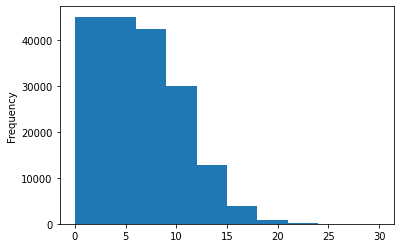

In [ ]:
train_df['line_number'].plot.hist();

In [ ]:
train_line_number_one_hot = F.one_hot(torch.tensor(train_df['line_number']), num_classes=31)
val_line_number_one_hot = F.one_hot(torch.tensor(val_df['line_number']), num_classes=31)
test_line_number_one_hot = F.one_hot(torch.tensor(test_df['line_number']), num_classes=31)

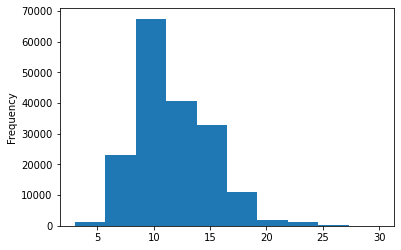

In [ ]:
train_df['total_lines'].plot.hist();

In [ ]:
# train_total_line_number_one_hot = F.one_hot(torch.tensor(train_df['total_lines']), num_classes=31)
# val_total_line_number_one_hot = F.one_hot(torch.tensor(val_df['total_lines']), num_classes=31)
# test_total_line_number_one_hot = F.one_hot(torch.tensor(test_df['total_lines']), num_classes=31)

In [ ]:
# F.one_hot(torch.tensor(train_df['total_lines']), num_classes=31)

In [ ]:
import tensorflow as tf

train_total_line_number_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_line_number_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_line_number_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)


train_total_line_number_one_hot[:5], train_line_number_one_hot.shape

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>, torch.Size([180040, 31]))

In [ ]:
torch.LongTensor(train_total_line_number_one_hot.numpy())

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
tf.one_hot(train_df['total_lines'][0], depth=20).numpy()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

## Creating Dataset

In [ ]:
class SkimlitDataset(Dataset):
  def __init__(self, text_seq, target, line_num_one_hot, total_line_one_hot):
    self.text_seq = text_seq
    self.target = target
    self.line_num_one_hot = line_num_one_hot
    self.total_line_one_hot = total_line_one_hot

  def __len__(self):
    return len(self.target)

  def __str__(self):
    return f"<Dataset(N={len(self)})>"

  def __getitem__(self, index):
    X = self.text_seq[index]
    y = self.target[index]
    line_num = self.line_num_one_hot[index]
    total_line = self.total_line_one_hot[index]
    return [X, len(X), line_num, total_line, y]
  
  def collate_fn(self, batch):
    """Processing on a batch"""
    # Getting Input
    batch = np.array(batch)
    text_seq = batch[:,0]
    seq_lens = batch[:, 1]
    line_nums = batch[:, 2]
    total_lines = batch[:, 3]
    target = batch[:, 4]

    # padding inputs
    pad_text_seq = pad_sequences(sequences=text_seq) # max_seq_len=max_length

    # converting line nums into one-hot encoding
    # line_nums = F.one_hot(torch.LongTensor(line_nums.astype(np.int32)), num_classes=31)
    line_nums = tf.one_hot(line_nums, depth=31)

     # converting total lines into one-hot encoding
    # total_lines = F.one_hot(torch.LongTensor(total_lines.astype(np.int32)), num_classes=31)
    total_lines = tf.one_hot(total_lines, depth=31)

    # converting inputs to tensors
    pad_text_seq = torch.LongTensor(pad_text_seq.astype(np.int32))
    seq_lens = torch.LongTensor(seq_lens.astype(np.int32))
    line_nums = torch.tensor(line_nums.numpy())
    total_lines = torch.tensor(total_lines.numpy())
    target = torch.LongTensor(target.astype(np.int32))
    
    return pad_text_seq, seq_lens, line_nums, total_lines,  target

  def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
    dataloader = DataLoader(dataset=self, batch_size=batch_size, collate_fn=self.collate_fn, shuffle=shuffle, drop_last=drop_last, pin_memory=True)
    return dataloader

In [ ]:
# Create datasets
train_dataset = SkimlitDataset(text_seq=X_train, target=y_train, line_num_one_hot=train_df['line_number'], total_line_one_hot=train_df['total_lines'])
val_dataset = SkimlitDataset(text_seq=X_val, target=y_val, line_num_one_hot=val_df['line_number'], total_line_one_hot=val_df['total_lines'])
test_dataset = SkimlitDataset(text_seq=X_test, target=y_test, line_num_one_hot=test_df['line_number'], total_line_one_hot=test_df['total_lines'])

In [ ]:
train_dataset[0]

[array([ 1981,   561,    55,  7061,     5,   244,    51, 10466,  2033,
          862,    19,  1194,    14,   166]), 14, 0, 11, 4]

In [ ]:
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(1970, 422, 422)

In [ ]:
batch_text_seq, batch_seq_len, batch_line_num, batch_total_line, batch_target = next(iter(train_dataloader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
batch_line_num.shape, batch_total_line.shape, batch_line_num 

(torch.Size([64, 31]),
 torch.Size([64, 31]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [ ]:
batch_text_seq

tensor([[ 1981,   561,    55,  ...,     0,     0,     0],
        [   70, 12571,   282,  ...,     0,     0,     0],
        [ 1180,     7,    12,  ...,     0,     0,     0],
        ...,
        [  397,    53, 16680,  ...,     0,     0,     0],
        [ 1911,  2311,   641,  ...,     0,     0,     0],
        [  114,    28, 16681,  ...,     0,     0,     0]])

## Model Class

In [ ]:
class SkimlitModel(nn.Module):
  def __init__(self, embedding_dim, vocab_size, hidden_dim, n_layers, linear_output, num_classes, pretrained_embeddings=None, padding_idx=0):
    super(SkimlitModel, self).__init__()

    # Initalizing embeddings
    if pretrained_embeddings is None:
      self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    else:
      pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
      self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, _weight=pretrained_embeddings, padding_idx=padding_idx)

    # LSTM layers
    self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)

    # FC layers
    self.fc_text = nn.Linear(2*hidden_dim, linear_output)

    self.fc_line_num = nn.Linear(31, 64)
    self.fc_total_line = nn.Linear(31, 64)

    self.fc_final = nn.Linear((64+64+linear_output), num_classes)
    # self.fc_final = nn.Linear(linear_output, num_classes)
    self.dropout = nn.Dropout(0.3)

  def forward(self, inputs):
    x_in, seq_lens, line_nums, total_lines = inputs
    x_in = self.embeddings(x_in)

    # RNN outputs 
    out, b_n = self.lstm1(x_in)
    x_1 = gather_last_relevant_hidden(hiddens=out, seq_lens=seq_lens)

    # FC layers output
    x_1 = F.relu(self.fc_text(x_1))
    x_2 = self.fc_line_num(line_nums)
    x_3 = F.relu(self.fc_total_line(total_lines))

    x = torch.cat((x_1, x_2, x_3), dim=1)
    x = self.dropout(x)
    x = self.fc_final(x)
    return x

In [ ]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 128

model = SkimlitModel(
    embedding_dim=EMBEDDING_DIM,
    vocab_size=VOCAB_SIZE,
    hidden_dim=HIDDEN_DIM,
    n_layers=2,
    linear_output= 128,
    num_classes=NUM_CLASSES,
    pretrained_embeddings=embedding_matrix,
)

model = model.to(device)
model

SkimlitModel(
  (embeddings): Embedding(38831, 300, padding_idx=0)
  (lstm1): LSTM(300, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc_text): Linear(in_features=256, out_features=128, bias=True)
  (fc_line_num): Linear(in_features=31, out_features=64, bias=True)
  (fc_total_line): Linear(in_features=31, out_features=64, bias=True)
  (fc_final): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## Training

In [ ]:
LEARNING_RATE=1e-4
PATIENCE = 5
NUM_EPOCHS = 25

# Define Loss
class_weights_tensor = torch.LongTensor(list(class_weights.values())).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
trainer = Trainer(
    model=model,
    device=device,
    loss_fn=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    save_path = '/content/drive/MyDrive/Datasets/SkimLit/skimlit_Pytorch_2.pt', 
)

In [ ]:
best_model = trainer.train(
    NUM_EPOCHS,
    PATIENCE, 
    train_dataloader,
    val_dataloader,
)

<----- Epoch: 1 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


  0%|          | 0/422 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Saving Model!!
train_loss: 0.89262,	train_loss: 0.64,
val_loss: 0.72536, 	val_loss: 0.72, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 2 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Saving Model!!
train_loss: 0.66233,	train_loss: 0.75,
val_loss: 0.63845, 	val_loss: 0.76, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 3 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Saving Model!!
train_loss: 0.58822,	train_loss: 0.78,
val_loss: 0.61082, 	val_loss: 0.77, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 4 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Saving Model!!
train_loss: 0.53777,	train_loss: 0.80,
val_loss: 0.60466, 	val_loss: 0.78, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 5 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.49680,	train_loss: 0.82,
val_loss: 0.60880, 	val_loss: 0.78, 
lr: 1.00E-04, 	_patience: 4

<----- Epoch: 6 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.46141,	train_loss: 0.83,
val_loss: 0.63005, 	val_loss: 0.78, 
lr: 1.00E-04, 	_patience: 3

<----- Epoch: 7 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.43051,	train_loss: 0.85,
val_loss: 0.64806, 	val_loss: 0.78, 
lr: 1.00E-04, 	_patience: 2

<----- Epoch: 8 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train_loss: 0.40306,	train_loss: 0.86,
val_loss: 0.67424, 	val_loss: 0.77, 
lr: 1.00E-05, 	_patience: 1

<----- Epoch: 9 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Stopping early!


## Evaluation

In [ ]:
# Get predictions
test_loss, test_acc, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)
print(f"Test Accuracy: {test_acc/len(test_dataloader)}")

# Determine performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

  0%|          | 0/422 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy: 0.7779100137290303
{
  "precision": 0.774319956582693,
  "recall": 0.7779094308882882,
  "f1": 0.7756958381209453,
  "num_samples": 27007.0
}
